In [1]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)


import utils.NN_building as NN_building
import src.NN_pipeline as NN_pipeline  
import utils.NN_preprocessing as NN_preprocessing 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import pdb
import matplotlib.pyplot as plt 



# Mutual information between variables and zero_perc
def calculate_mi_feature(data, target, other_features,type):
        if type == 'classification':
            mi = mutual_info_classif(data[other_features], data[target], random_state=0)
        elif type == 'regression':
            mi = mutual_info_regression(data[other_features], data[target], random_state=0)
        mi_df = pd.DataFrame({'feature': other_features, 'mi': mi})

        return mi_df
    


def plot_mi_feature(mi_df):
    mi_df = mi_df.sort_values('mi', ascending=False).reset_index(drop=True)  
    # Plot mutual information
    plt.figure(figsize=(20,5))
    plt.bar(mi_df['feature'],mi_df['mi'])
    plt.xticks(rotation=90)
    plt.ylabel('Coeficiente de Informação Mútua')
    plt.xlabel('Variáveis')
    plt.show()

### Regression


#### Ntrap = 10, lags = 5  

In [23]:
# Model parameters

parameters = {
    'ntraps': 10,
    'lags': 5,
    'model_type': 'catboost_reg',   
    'use_trap_info': True,
    'add_constant': True,
    'scale': True,
    'cylindrical_input': True,
    'split_type': 'year',
    'bool_input': False,
    'truncate_100': False,
    'input_3_class':False,
    'year_list_train': ['2011_12', '2012_13', '2013_14', '2014_15', '2015_16', '2016_17', '2017_18', '2018_19', '2019_20', '2020_21', '2021_22'],
    'year_list_test': ['2022_23', '2023_24', '2024_25'],
    'month_experiment': False,
    'input_3d': False,
    'add_constant':True,
    'all_cols': True,
    'info_cols':[],
    'limit':0
    }


data_path = f"../results/final_dfs/final_df_lag{parameters['lags']}_ntraps{parameters['ntraps']}.parquet"

data = pd.read_parquet(data_path)
unnamed_cols = data.columns [['Unnamed' in col for col in data.columns] ] #TODO create function to load data
data.drop(unnamed_cols,axis=1,inplace = True)

x_train, x_test, y_train, y_test, index_dict= NN_pipeline.create_dataset(parameters,data_path)


In [30]:
(data['novos'] == 0).sum()/len(data['novos'])

0.6021533194645762

In [31]:
(y_train == 0).sum()/len(y_train)

0.6163477406947722

In [32]:
(y_test == 0).sum()/len(y_test)

0.5519674660837137

In [36]:
data.columns[100:]

Index(['trap8_lag3', 'trap8_lag4', 'trap8_lag5', 'latitude8', 'longitude8',
       'days8_lag1', 'days8_lag2', 'days8_lag3', 'days8_lag4', 'days8_lag5',
       'trap9_lag1', 'trap9_lag2', 'trap9_lag3', 'trap9_lag4', 'trap9_lag5',
       'latitude9', 'longitude9', 'days9_lag1', 'days9_lag2', 'days9_lag3',
       'days9_lag4', 'days9_lag5', 'mesepid', 'zero_perc', 'semepi', 'anoepid',
       'temp_expo', 'semepi2', 'sin_semepi', 'sin_mesepi', '3_class',
       'Temperatura_previsao', 'Precipitacao_previsao', 'Umidade_previsao',
       'Temperatura_week_bfr_mean', 'Precipitacao_week_bfr_mean',
       'Umidade_week_bfr_mean'],
      dtype='object')

In [ ]:
data.groupby('anoepid').apply(lambda x: (x['novos'] == 0).sum()/len(x))

C:\Users\User\AppData\Local\Temp\ipykernel_19720\3595831407.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('anoepid').apply(lambda x: (x['novos'] == 0).sum()/len(x))


anoepid
2011_12    0.539841
2012_13    0.615882
2013_14    0.640150
2014_15    0.654157
2015_16    0.585457
2016_17    0.677358
2017_18    0.676822
2018_19    0.524434
2019_20    0.633848
2020_21    0.609619
2021_22    0.556804
2022_23    0.573279
2023_24    0.491547
2024_25    0.659497
dtype: float64

: 

In [24]:
# Calculate mutual information
mi = mutual_info_regression(x_train, y_train, random_state=0)
mutual_info_df = pd.DataFrame({'feature': x_train.columns, 'mi': mi})
mutual_info_df = mutual_info_df.sort_values('mi', ascending=False).reset_index(drop=True)   


In [25]:
lat_ = [x for x in x_train.columns if 'latitude' in x][1:]
lon_ = [x for x in x_train.columns if 'longitude' in x][1:]

day_ = [x for x in x_train.columns if 'day' in x]
lon_lat = lat_ + lon_ + day_ + ['temp_expo']


In [26]:
mi_latitude0_df = mutual_info_df[~mutual_info_df['feature'].isin(lon_lat)]


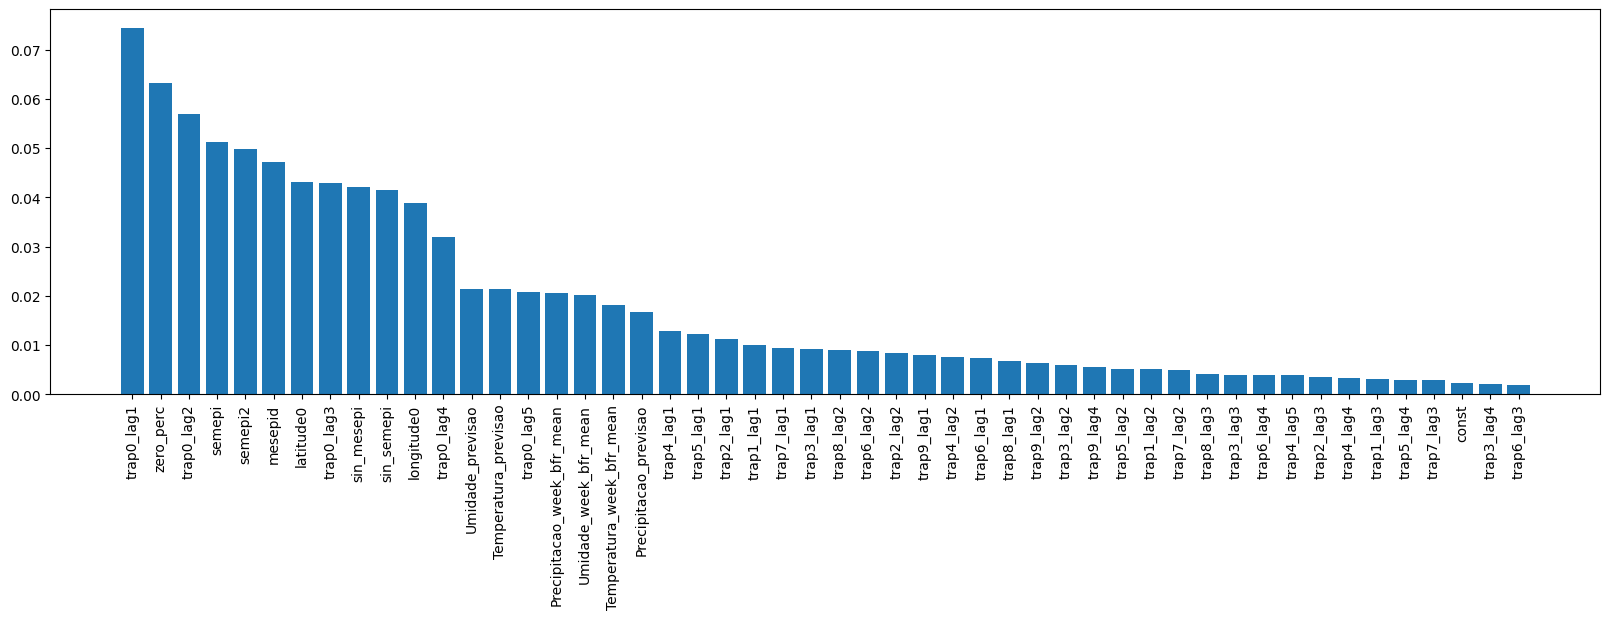

In [27]:
# Plot mutual information
plt.figure(figsize=(20,5))
plt.bar(mi_latitude0_df['feature'].iloc[:50],mi_latitude0_df['mi'].iloc[:50])
plt.xticks(rotation=90)
plt.show()


In [7]:
long_df = calculate_mi_feature(x_train, 'longitude0', list(set(mutual_info_df['feature'].to_list()) - set(day_)),'regression')
lat_df = calculate_mi_feature(x_train, 'latitude0', list(set(mutual_info_df['feature'].to_list()) - set(day_)),'regression')


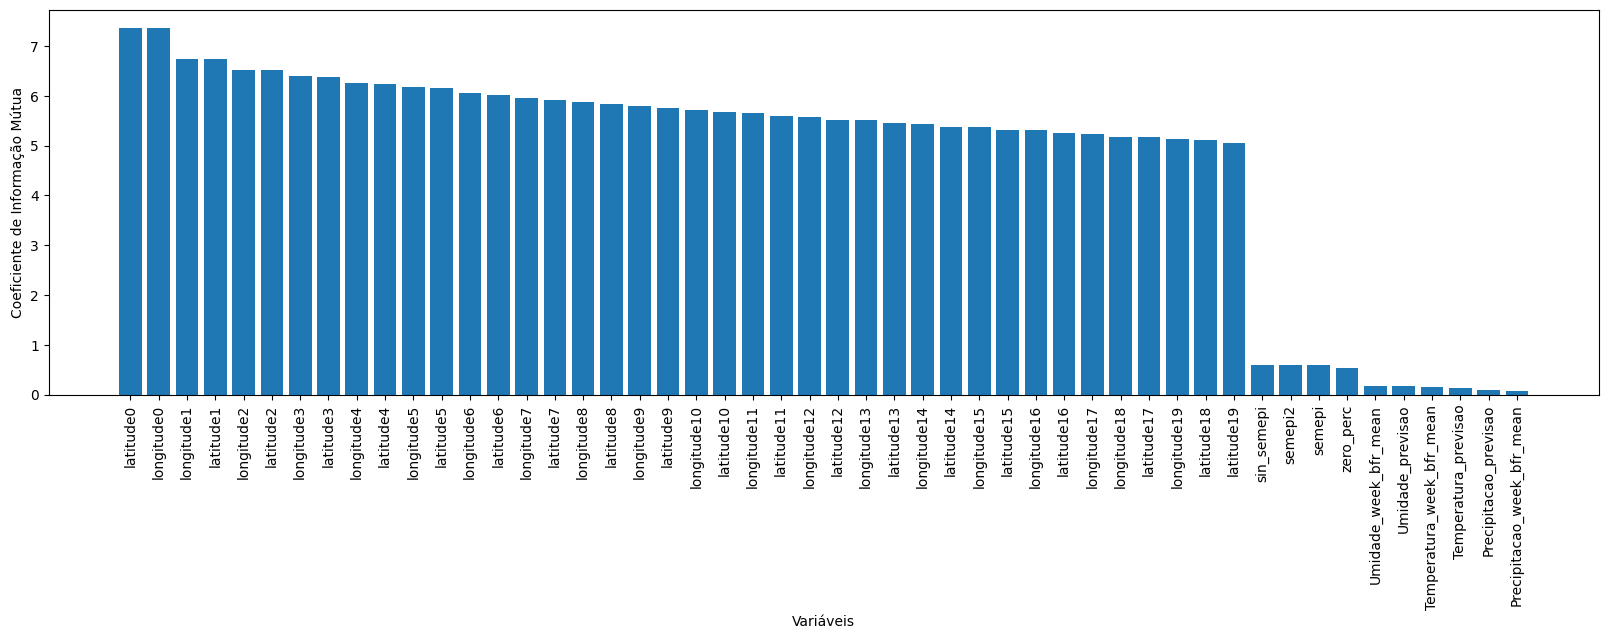

In [ ]:
long_df = long_df.sort_values('mi', ascending=False).reset_index(drop=True)
mi_trap0_lag14_df = plot_mi_feature(long_df.iloc[:50])


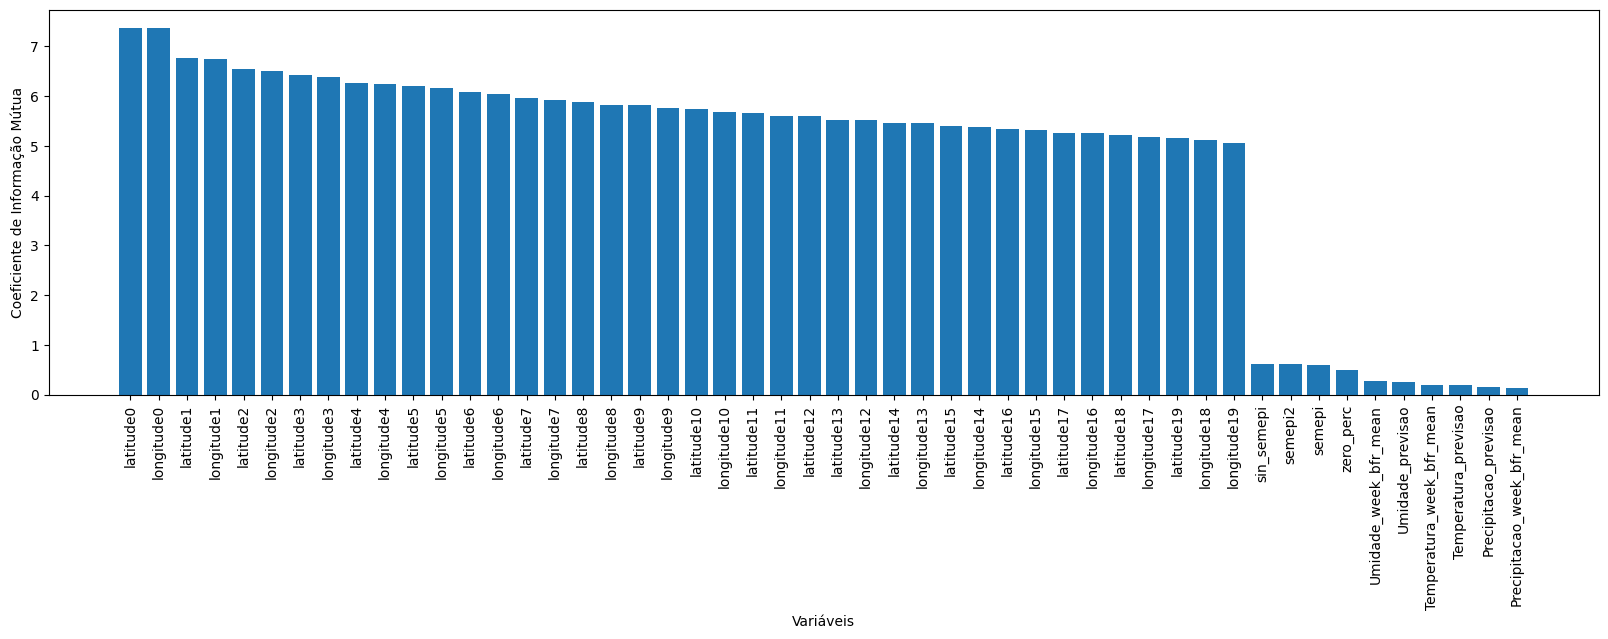

In [22]:
lat_df=lat_df.sort_values('mi', ascending=False).reset_index(drop=True)
mi_trap0_lag14_df = plot_mi_feature(lat_df.iloc[:50])


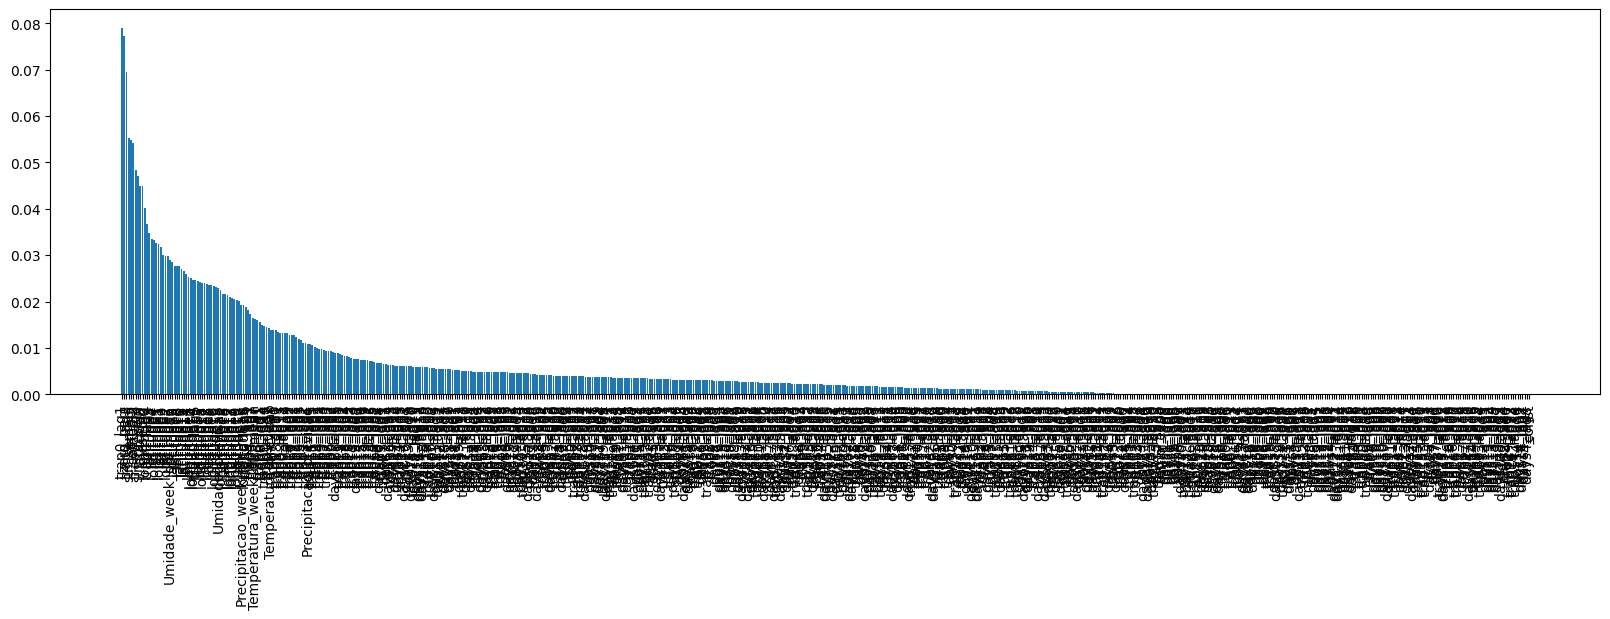

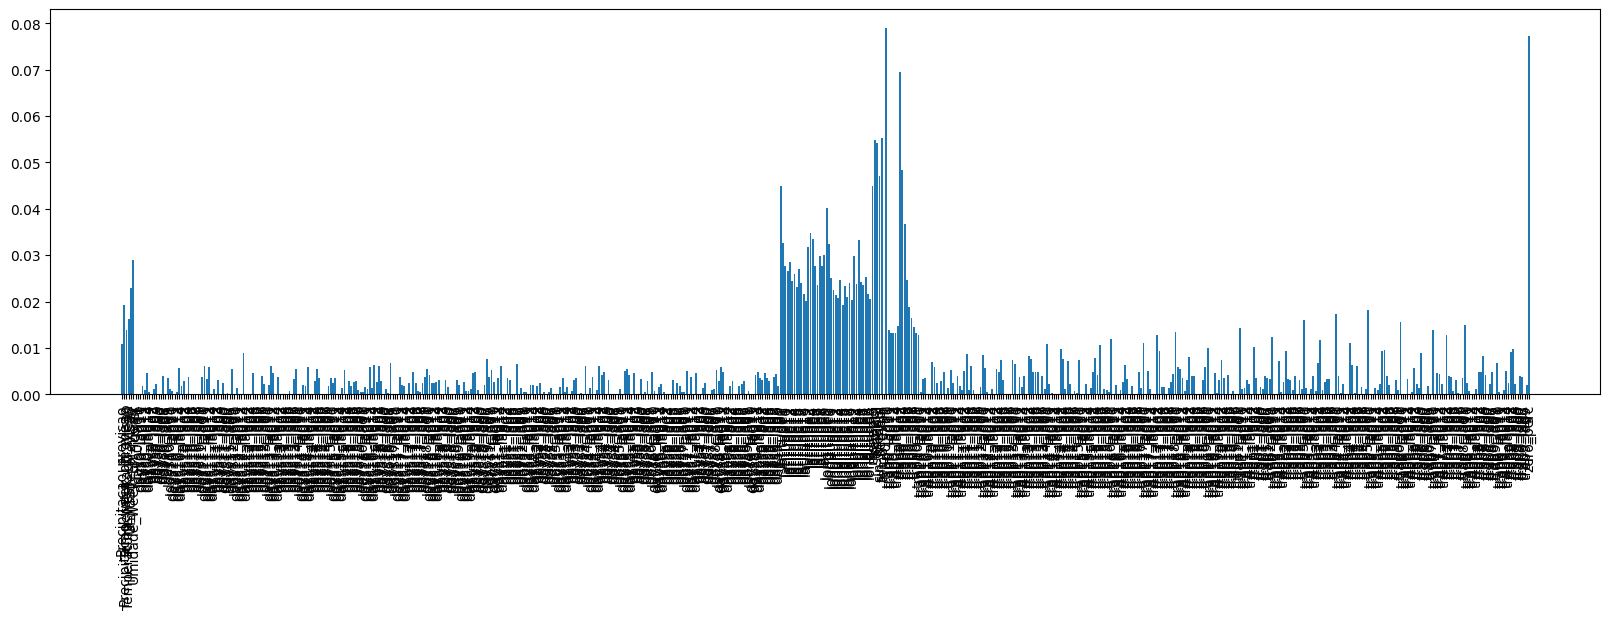

In [11]:
# Plot mutual information
plt.figure(figsize=(20,5))
plt.bar(mutual_info_df['feature'],mutual_info_df['mi'])
plt.xticks(rotation=90)
plt.show()


mutual_info_df.sort_values('feature', inplace=True)
# Plot mutual information
plt.figure(figsize=(20,5))
plt.bar(mutual_info_df['feature'],mutual_info_df['mi'])
plt.xticks(rotation=90)
plt.show()

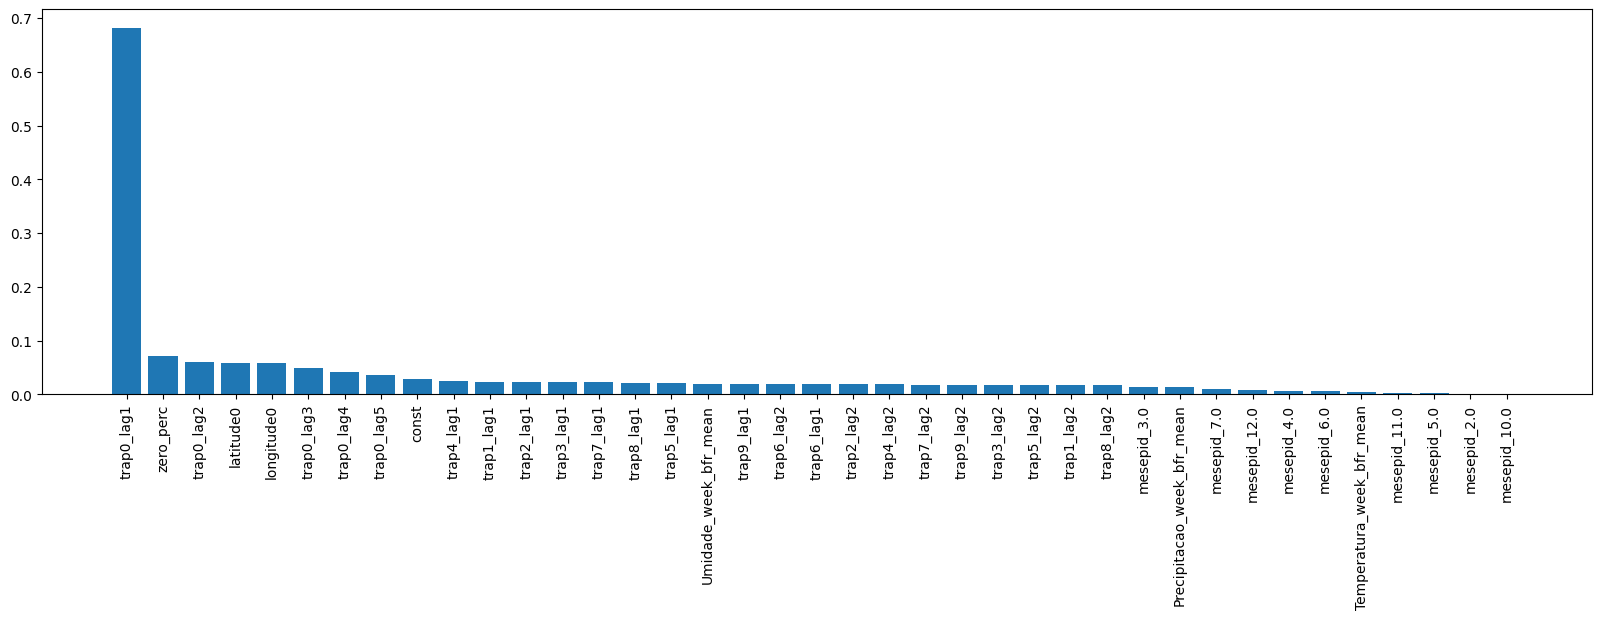

In [18]:
mi_trap0_lag14_df = plot_mi_feature(x_train, 'trap0_lag1', mutual_info_df['feature'].to_list(),'classification')


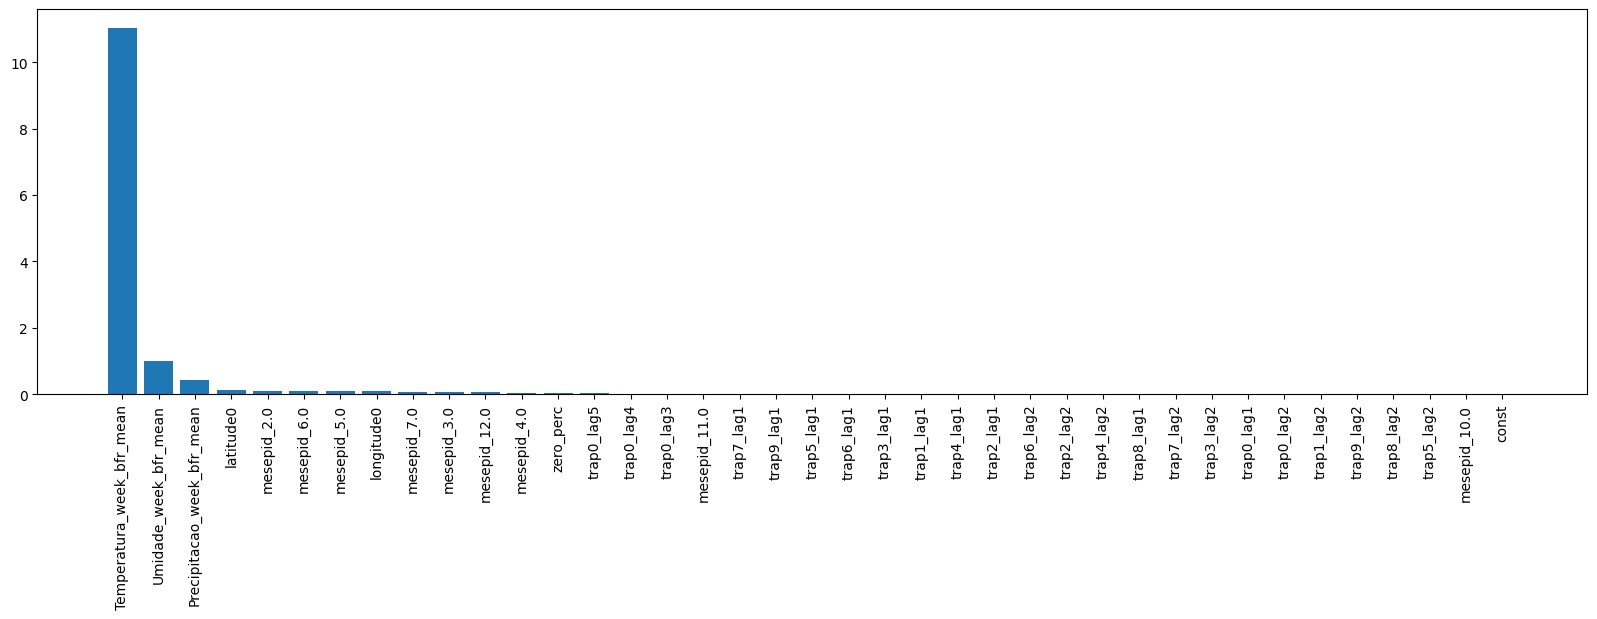

In [20]:
mi_trap0_lag14_df = plot_mi_feature(x_train, 'Temperatura_week_bfr_mean', mutual_info_df['feature'].to_list(),'regression')

In [26]:
x_train.iloc[:,-13:]

,zero_perc,Temperatura_week_bfr_mean,Precipitacao_week_bfr_mean,Umidade_week_bfr_mean,mesepid_2.0,mesepid_3.0,mesepid_4.0,mesepid_5.0,mesepid_6.0,mesepid_7.0,mesepid_10.0,mesepid_11.0,mesepid_12.0
0,1.000000,0.733547,0.311441,0.865878,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.800000,0.734820,0.323330,0.866746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.800000,0.733907,0.314755,0.866144,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.800000,0.733503,0.311190,0.865973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.000000,0.733884,0.314682,0.866237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219952,0.593023,0.636081,0.000016,0.734723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
219953,0.643443,0.636480,0.000015,0.734498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
219954,0.491329,0.636184,0.000016,0.734488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
219955,0.594262,0.636147,0.000015,0.734913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
